# OSMnx

Testing the [OSMnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) library for loading and processing OSM data.

See these [notebooks](https://github.com/gboeing/osmnx-examples/tree/master/notebooks) for examples of using the library.

In [ ]:
# !brew install spatialindex

In [65]:
import networkx as nx
import itertools
import osmnx as ox
import glob
import itertools
from matplotlib import cm
import folium
import matplotlib.pyplot as plt
import time
import numpy as np

%matplotlib inline
ox.config(log_console=True, use_cache=True, data_folder='')

In [2]:
graphml_fnames = glob.glob('data/boeing_dataverse/06-CA-cities-street_networks-graphml/*.graphml')

In [3]:
def remove_parallels(G):
    parallel_edges = [(u, v, key) for (u, v, key) in G.edges(keys=True) if key != 0]
    G.remove_edges_from(parallel_edges)

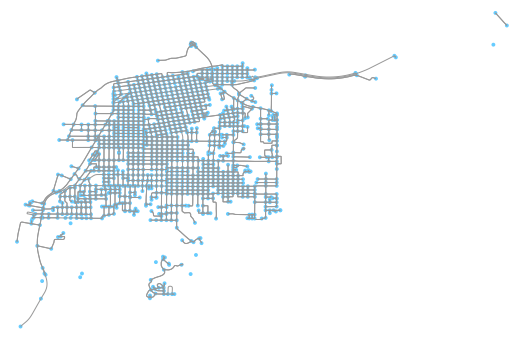

06_CA_0623042_Eureka


In [109]:
G = ox.load_graphml(graphml_fnames[12])
remove_parallels(G)
fig, ax = ox.plot_graph(G)
print(G.graph['name'])

In [102]:
def simulate_step(G_sim, edge_capacities):
    betw_cent = nx.edge_betweenness_centrality(G_sim, weight='length')
    
    failed = [(u, v) for (u, v, key) in G_sim.edges(keys=True)
                 if betw_cent[(u,v)] > edge_capacities[(u,v)]]
    
    G_sim.remove_edges_from(failed)
    
    return failed


def simulation(G, failed, edge_capacities, verbose=False):
    # note modifies G
    
    nx.set_edge_attributes(G, -1, 'failure_step')
    G_sim = G.copy()
    G_sim.remove_edges_from(failed)
     
    step = 0
    while len(failed) > 0:
        if verbose:
            print('stepping')
        nx.set_edge_attributes(G, {(u, v, 0): step for (u, v) in failed}, 'failure_step')
        failed = simulate_step(G_sim, edge_capacities)
        step += 1
        
    return step

In [103]:
betw_cent = nx.edge_betweenness_centrality(G, weight='length')
edge_capacities = {k: v * 1.5 for k, v in betw_cent.items()}

max_betw_cent_edge = max(betw_cent, key=betw_cent.get)
max_betw_cent = betw_cent[max_betw_cent_edge]

max_step = simulation(G, [max_betw_cent_edge], edge_capacities, verbose=True)

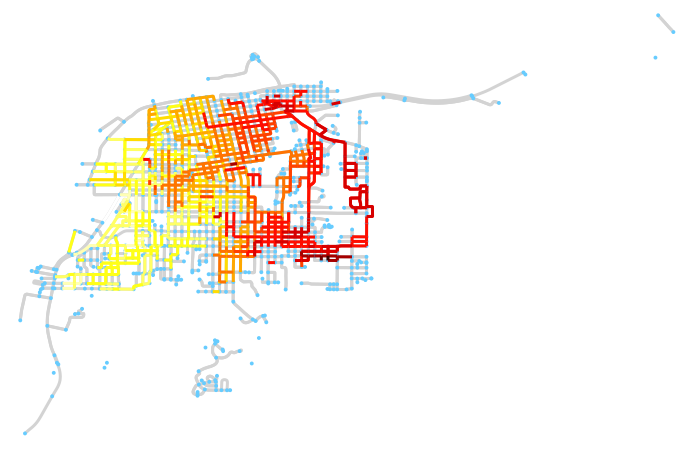

In [105]:
ec = ['lightgrey' if d['failure_step'] == -1 else cm.hot(1 - d['failure_step'] / max_step)
      for (u,v,d) in G.edges(data=True)] 

ez = [d['failure_step'] + 1 for (u,v,d) in G.edges(data=True)]

fig, ax = plot_graph(G, edge_color=ec, fig_height=8,
                     annotate=False, use_geom=True, edge_linewidth=3,
                     edge_alpha=1, edge_zorder=ez)

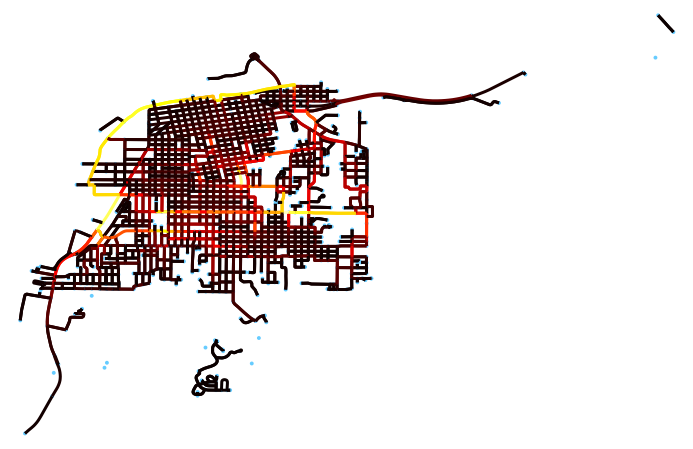

In [106]:
# highlight all parallel edges in purple
ec = [cm.hot(betw_cent[(u,v)] / max_betw_cent) for u, v in G.edges()]
ez = np.argmax(np.array([cm.viridis(betw_cent[(u,v)] / max_betw_cent) for u, v in G.edges()]))

fig, ax = plot_graph(G, edge_color=ec, fig_height=8,
                     annotate=False, use_geom=True, edge_linewidth=3,
                     edge_alpha=1, edge_zorder=ez)

In [83]:
from osmnx.save_load import graph_to_gdfs
from matplotlib.collections import LineCollection


def plot_graph(G, bbox=None, fig_height=6, fig_width=None, margin=0.02,
               axis_off=True, equal_aspect=False, bgcolor='w', show=True,
               save=False, close=True, file_format='png', filename='temp',
               dpi=300, annotate=False, node_color='#66ccff', node_size=15,
               node_alpha=1, node_edgecolor='none', node_zorder=1,
               edge_color='#999999', edge_linewidth=1, edge_alpha=1, edge_zorder=2,
               use_geom=True):

    #log('Begin plotting the graph...')
    node_Xs = [float(x) for _, x in G.nodes(data='x')]
    node_Ys = [float(y) for _, y in G.nodes(data='y')]

    # get north, south, east, west values either from bbox parameter or from the
    # spatial extent of the edges' geometries
    if bbox is None:
        edges = graph_to_gdfs(G, nodes=False, fill_edge_geometry=True)
        west, south, east, north = edges.total_bounds
    else:
        north, south, east, west = bbox

    # if caller did not pass in a fig_width, calculate it proportionately from
    # the fig_height and bounding box aspect ratio
    bbox_aspect_ratio = (north-south)/(east-west)
    if fig_width is None:
        fig_width = fig_height / bbox_aspect_ratio

    # create the figure and axis
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), facecolor=bgcolor)
    ax.set_facecolor(bgcolor)

    # draw the edges as lines from node to node
    start_time = time.time()
    lines = []
    for u, v, data in G.edges(keys=False, data=True):
        if 'geometry' in data and use_geom:
            # if it has a geometry attribute (a list of line segments), add them
            # to the list of lines to plot
            xs, ys = data['geometry'].xy
            lines.append(list(zip(xs, ys)))
        else:
            # if it doesn't have a geometry attribute, the edge is a straight
            # line from node to node
            x1 = G.nodes[u]['x']
            y1 = G.nodes[u]['y']
            x2 = G.nodes[v]['x']
            y2 = G.nodes[v]['y']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

    # add the lines to the axis as a linecollection
    if not isinstance(edge_color, list):
        edge_color = [edge_color] * len(lines)
    if not isinstance(edge_linewidth, list):
        edge_linewidth = [edge_linewidth] * len(lines)
    if not isinstance(edge_alpha, list):
        edge_alpha = [edge_alpha] * len(lines)
    if not isinstance(edge_zorder, list):
        edge_zorder = [edge_zorder] * len(lines)
        
    for i in range(len(lines)):
        lc = LineCollection(lines[i:i+1],
                            colors=edge_color[i:i+1],
                            linewidths=edge_linewidth[i:i+1], #TODO FIX!
                            alpha=edge_alpha[i],
                            zorder=edge_zorder[i])
        ax.add_collection(lc)
    #log('Drew the graph edges in {:,.2f} seconds'.format(time.time()-start_time))

    # scatter plot the nodes
    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color, alpha=node_alpha, edgecolor=node_edgecolor, zorder=node_zorder)

    # set the extent of the figure
    margin_ns = (north - south) * margin
    margin_ew = (east - west) * margin
    ax.set_ylim((south - margin_ns, north + margin_ns))
    ax.set_xlim((west - margin_ew, east + margin_ew))

    # configure axis appearance
    xaxis = ax.get_xaxis()
    yaxis = ax.get_yaxis()

    xaxis.get_major_formatter().set_useOffset(False)
    yaxis.get_major_formatter().set_useOffset(False)

    # if axis_off, turn off the axis display set the margins to zero and point
    # the ticks in so there's no space around the plot
    if axis_off:
        ax.axis('off')
        ax.margins(0)
        ax.tick_params(which='both', direction='in')
        xaxis.set_visible(False)
        yaxis.set_visible(False)
        fig.canvas.draw()

    if equal_aspect:
        # make everything square
        ax.set_aspect('equal')
        fig.canvas.draw()
    else:
        # if the graph is not projected, conform the aspect ratio to not stretch the plot
        if G.graph['crs'] == ox.settings.default_crs:
            coslat = np.cos((min(node_Ys) + max(node_Ys)) / 2. / 180. * np.pi)
            ax.set_aspect(1. / coslat)
            fig.canvas.draw()

    # annotate the axis with node IDs if annotate=True
    if annotate:
        for node, data in G.nodes(data=True):
            ax.annotate(node, xy=(data['x'], data['y']))

    # save and show the figure as specified
    fig, ax = ox.save_and_show(fig, ax, save, show, close, filename, file_format, dpi, axis_off)
    return fig, ax